# Analysis and Design of Multi-Layer Neural Networks (MLP)

## Table of Contents
- [MLP Design](#mlp-design)
- [Train Two Different Models](#train-two-different-models)
- [Back Propagation Algorithm](#back-propagation-algorithm)
- [Analysis of Different Hyperparameters](#analysis-of-different-hyperparameters)
- [References](#references)

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.optim as optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

np.random.seed(42)
torch.manual_seed(42)

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

cuda


In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

one issue was I tried to set the transformer this lambda bellow and the test loss was unbelievable!

In [4]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] 
    # transforms.Lambda(lambda x: x / 255)
])
test_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

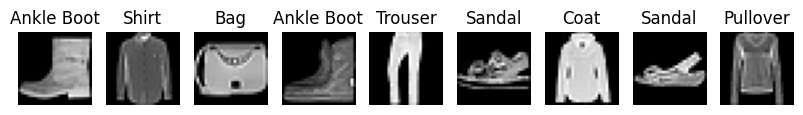

In [5]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 9,1
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## MLP Design

In [6]:
class Model(nn.Module):
    def __init__(self, h1, do_rate=0, in_features=28*28, out_features=10):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.dropout = nn.Dropout(do_rate)
        self.out = nn.Linear(h1, out_features)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

In [7]:
class Plotter:
    def __init__(self):
        pass

    @staticmethod
    def plot_curve(data, title: str):
        scale_x = range(1, len(data) + 1)

        plt.figure(figsize=(10, 4))
        plt.plot(scale_x, data)
        plt.xlabel("Epochs")
        plt.ylabel("SSE (Sum Squared Error)")
        plt.title(title)
        plt.show()

    @staticmethod        
    def plot_acc(train_acc, val_acc, name):
        plt.plot(train_acc, label=f'{name} Train Acc')
        plt.plot(val_acc, label=f'{name} Val Acc')

        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

    @staticmethod
    def plot_loss():
        pass

    @staticmethod
    def plot_confusion_matrix(labels, preds, classes):
        cm = confusion_matrix(labels, preds)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.title('Confusion Matrix')
        plt.show()
        return cm

In [8]:
class MLP():
    def __init__(self, model):
        self.model = model
        self.criteria = nn.CrossEntropyLoss()
        self.lambda_reg = 0.0001
        self.learning_rate = 0.01

    def forward(self, images, labels):
        # Forward pass
        outputs = self.model(images)
        loss = self.criteria(outputs, labels)
        return outputs, loss
    
    def calc_epoch_corrects(self, outputs, labels):
        self.all_preds.extend(outputs)
        self.all_labels.extend(labels)

        _, predicted = torch.max(outputs, 1)
        return (predicted == labels).sum().item()

    def apply_l2_regularization(self, loss):
        l2_reg = 0
        for param in self.model.parameters():
            l2_reg += torch.sum(param ** 2)
        loss += self.lambda_reg * l2_reg
        return loss

    def evaluate(self, loader):
        self.model.to(device)
        self.model.eval()
        all_preds = []
        all_labels = []
        running_loss = 0.0

        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                outputs, loss = self.forward(images, labels)
                loss += self.apply_l2_regularization(loss)

                running_loss += loss.item() # * images.size(0)  # is the batch size
                _, predicted = torch.max(outputs, dim=1)
                all_preds.extend(predicted.cpu().detach().numpy())
                all_labels.extend(labels.cpu().detach().numpy())

        return ((running_loss / len(loader.dataset))), accuracy_score(all_labels, all_preds)

    def train(self, loader):
        self.model.to(device)
        self.model.train()
        all_preds = []
        all_labels = []
        running_loss = 0.0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs, loss = self.forward(images, labels)
            loss += self.apply_l2_regularization(loss)

            self.model.zero_grad()
            loss.backward()

            with torch.no_grad():
                for param in self.model.parameters():
                    param -= self.learning_rate * param.grad
                    
            running_loss += loss.item() # * images.size(0)  # is the batch size
            _, predicted = torch.max(outputs, dim=1)
            all_preds.extend(predicted.cpu().detach().numpy())
            all_labels.extend(labels.cpu().detach().numpy())
        # print(all_preds)
        # print(all_labels)    
        return ((running_loss / len(loader.dataset))), accuracy_score(all_labels, all_preds)

    def test(self, loader):
        return self.evaluate(loader)

In [9]:
m = MLP(Model(100, do_rate=0.3))

In [10]:
num_epochs = 20

for epoch in range(num_epochs):
    train_loss, train_acc = m.train(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

Epoch [1/20], Train Loss: 0.0234, Train Acc: 0.7429
Epoch [2/20], Train Loss: 0.0164, Train Acc: 0.8171
Epoch [3/20], Train Loss: 0.0150, Train Acc: 0.8327
Epoch [4/20], Train Loss: 0.0141, Train Acc: 0.8424
Epoch [5/20], Train Loss: 0.0136, Train Acc: 0.8492
Epoch [6/20], Train Loss: 0.0130, Train Acc: 0.8538
Epoch [7/20], Train Loss: 0.0127, Train Acc: 0.8596
Epoch [8/20], Train Loss: 0.0124, Train Acc: 0.8626
Epoch [9/20], Train Loss: 0.0121, Train Acc: 0.8645
Epoch [10/20], Train Loss: 0.0120, Train Acc: 0.8678
Epoch [11/20], Train Loss: 0.0117, Train Acc: 0.8701
Epoch [12/20], Train Loss: 0.0117, Train Acc: 0.8702
Epoch [13/20], Train Loss: 0.0114, Train Acc: 0.8744
Epoch [14/20], Train Loss: 0.0112, Train Acc: 0.8768
Epoch [15/20], Train Loss: 0.0111, Train Acc: 0.8771
Epoch [16/20], Train Loss: 0.0110, Train Acc: 0.8779
Epoch [17/20], Train Loss: 0.0108, Train Acc: 0.8791
Epoch [18/20], Train Loss: 0.0108, Train Acc: 0.8801
Epoch [19/20], Train Loss: 0.0107, Train Acc: 0.8821
Ep

In [11]:
test_loss, test_acc = m.test(test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Test Loss: 0.0226, Test Acc: 0.7698


In [12]:
print(classification_report(m.all_labels, m.all_preds, target_names=class_names, zero_division=0))

AttributeError: 'MLP' object has no attribute 'all_labels'

In [ ]:
cm = Plotter().plot_confusion_matrix(m.all_labels, m.all_preds, class_names)

In [ ]:
# class MLP:
#     def __init__(self, model_class, train_loader, val_loader, test_loader, lr=0.01, l2_reg=0.0001, epochs=20):
#         self.model_class = model_class
#         self.train_loader = train_loader
#         self.val_loader = val_loader
#         self.test_loader = test_loader
#         self.predicted_claasses = []
#         self.lr = lr
#         self.l2_reg = l2_reg
#         self.epochs = epochs
#         self.models = {}
#         self.optimizer = None
#         self.criterion = nn.CrossEntropyLoss()
#         # self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     def train_one_epoch(self, neuron_count):
#         epoch_loss = 0.0
#         for images, labels in self.train_loader:
#             # images, labels = images.to(device), labels.to(device)
#             outputs = self.model(images)
#             loss = self.criterion(outputs, labels)
            
#             l2_reg = 0
#             for param in self.model.parameters():
#                 l2_reg += torch.sum(param ** 2)
#             loss += self.model.l2_reg * l2_reg
#             self.model.zero_grad()
#             loss.backward()


#             with torch.no_grad():
#                 for param in self.model.parameters():
#                     param -= 0.001 * param.grad
#                 epoch_loss += loss.item()
        
#         print(f'Epoch [{epoch + 1}/{self.epochs}], Loss: {epoch_loss / len(train_loader):.4f}')
#     ############################################################3
#         model = self.models[neuron_count]
#         model.train()
#         running_loss = 0.0
#         running_acc = 0.0
#         for batch in self.train_loader:
#             inputs, labels = batch
#             # inputs, labels = inputs.to(self.device), labels.to(self.device)
            
#             # Forward pass
#             self.optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = self.criterion(outputs, labels)
            
#             # Backward and optimize
#             loss.backward()
#             self.optimizer.step()
#             running_loss += loss.item()
#             running_acc += accuracy_score(labels.cpu(), torch.argmax(outputs, dim=1).cpu())

#         self.models[neuron_count] = model
#         return running_loss / len(self.train_loader), running_acc / len(self.train_loader)

#     def evaluate(self, loader, neuron_count):
#         model = self.models[neuron_count]
#         model.eval()
#         all_preds = []
#         all_labels = []

#         with torch.no_grad():
#             inputs, labels = next(iter(loader))
#             inputs, labels = inputs.to(self.device), labels.to(self.device)

#             outputs = model(inputs)
#             _, preds = torch.max(outputs, dim=1)

#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#         # self.predicted_claasses = all_labels
#         self.models[neuron_count] = model
#         accuracy = accuracy_score(all_labels, all_preds)
#         return accuracy

#     def fit(self, neuron_count):
#         best_accuracy = 0
#         for epoch in range(self.epochs):
#             train_loss, train_acc = self.train_one_epoch(neuron_count)
#             val_accuracy = self.evaluate(self.val_loader, neuron_count)
#             print(f"Epoch [{epoch+1}/{self.epochs}], Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_accuracy:.4f}")

#             if val_accuracy > best_accuracy:
#                 best_accuracy = val_accuracy
#         last_accuracy = val_accuracy
#         return best_accuracy, last_accuracy

#     def train_with_hyperparams(self, h1_values):
#         results = {}
#         for h1 in h1_values:
#             model = self.model_class(h1)
#             self.optimizer = optim.Adam(model.parameters(), lr=self.lr, weight_decay=self.l2_reg)
#             model.to(self.device)

#             self.models[h1] = model
#             best_accuracy, last_accuracy = self.fit(h1)
#             self.plot_decision_boundary(model, self.val_loader, title=f"Decision Boundary for h1={h1}")
            
#             self.models[h1] = model
#             results[h1] = {'best_accuracy': best_accuracy, 'last_accuracy': last_accuracy} 
#             print(f'h1={h1}, Best Validation Accuracy: {best_accuracy:.4f}, Last Validation Accuracy: {last_accuracy:.4f}\n')

#         return results

#     def test_with_hyperparams(self, h1_values):
#         results = {}
#         for h1 in h1_values:
#             model = self.models[h1].to(self.device)
#             accuracy = self.evaluate(self.test_loader, h1)
#             self.plot_decision_boundary(model, self.test_loader, title=f"Decision Boundary for h1={h1}")
#             results[h1] = accuracy
#             print(f'h1={h1}, Test Accuracy: {accuracy:.4f}\n')

#     def plot_decision_boundary(self, model, loader, title="Decision Boundary"):
#         X = loader.dataset.tensors[0].cpu().numpy()
#         y = loader.dataset.tensors[1].cpu().numpy()

#         # Create a mesh grid over the feature space
#         x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
#         y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
#         xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), 
#                              np.linspace(y_min, y_max, 100))

#         # Predict over the grid
#         grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
#         grid = grid.to(next(model.parameters()).device)

#         with torch.no_grad():
#             Z = model(grid)
#             _, Z = torch.max(Z, dim=1)
#             Z = Z.cpu().numpy().reshape(xx.shape)

#         # Plot decision boundaries
#         plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
#         plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.coolwarm)
#         plt.title(title)
#         plt.xlabel("First Property")
#         plt.ylabel("Second Property")
#         plt.show()

In [ ]:
model = MLP(Model(100).to(device), train_dataset, test_dataset)

In [ ]:
# model.train()

In [ ]:
# model.evaluate()

In [ ]:
# conf_matrix = model.plot_confusion_matrix()

In [ ]:
# model = Model(100).to(device)
# criterion = nn.CrossEntropyLoss()  # Equivalent to sparse_categorical_crossentropy
# # optimizer = optim.Adam(model.parameters())
# model.parameters

In [ ]:
# num_epochs = 20

# losses = []
# model.train()
# for epoch in range(num_epochs):
#     epoch_loss = 0.0
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = model(images) # model.forward(images)
#         loss = criterion(outputs, labels)

#         l2_reg = 0
#         for param in model.parameters():
#             l2_reg += torch.sum(param ** 2)
#             # torch.norm(param)
#         loss += model.l2_reg * l2_reg
#         model.zero_grad()
#         loss.backward()

#         with torch.no_grad():
#             for param in model.parameters():
#                 param -= 0.01 * param.grad
#         epoch_loss += loss.item()
    
#     losses.append(epoch_loss)    
#     print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')

In [ ]:
# def plot_confusion_matrix(y_true, y_pred, classes):
#     cm = confusion_matrix(y_true, y_pred)
#     plt.figure(figsize=(10, 7))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.title('Confusion Matrix')
#     plt.show()
#     return cm

In [ ]:
# model.eval()
# all_labels = []
# all_preds = []

# with torch.no_grad():
#     for images, labels in test_loader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs, 1)

#         all_labels.extend(labels.cpu().numpy())
#         all_preds.extend(predicted.cpu().numpy())

# all_labels = np.array(all_labels)
# all_preds = np.array(all_preds)


In [ ]:
# conf_matrix = plot_confusion_matrix(all_labels, all_preds, test_dataset.classes)

In [ ]:
# most_confused = {}
# for i in range(10):
#     row = conf_matrix[i]
#     row[i] = 0
#     most_confused_class = np.argmax(row)
#     most_confused[i] = most_confused_class

# for m in range(10):
#     print(f"Class `{class_names[m]}` is most often confused with class `{class_names[most_confused[m]]}`")

In [ ]:
# conf_matrix_copy = conf_matrix.copy()
# np.fill_diagonal(conf_matrix_copy, 0)  # Zero the diagonal

# most_common_confusion = np.unravel_index(np.argmax(conf_matrix_copy), conf_matrix_copy.shape)

# # Print the most commonly confused classes
# print(f"The two most commonly confused classes are: `{class_names[most_common_confusion[0]]}` with `{class_names[most_common_confusion[1]]}`.")


#### Impact of Increasing Model Complexity

#### Criteria for Choosing the Best Configuration

- **Validation performance** : Monitor the validation accuracy and loss to ensure the model generalizes well.
- **Training stability** : Ensure that the model does not exhibit overfitting (training accuracy much higher than validation accuracy) or underfitting (both training and validation accuracies are low).
- **Computational efficiency** : Balance model complexity with computational resources (training time, memory usage).
- **Regularization** : Ensure proper regularization (e.g., dropout, L2 regularization) to prevent overfitting.

We can tune hyperparameters such as the number of layers, number of neurons per layer, regularization techniques, and learning rate to find the best configuration.

## Train Two Different Models

In [ ]:
# Load Fashion MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Example usage
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [ ]:
class Model(nn.Module):
    def __init__(self, h1, do_rate, l2_reg, in_features=28*28, out_features=10):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.dropout = nn.Dropout(do_rate)
        self.out = nn.Linear(h1, out_features)
        self.l2_reg = l2_reg
        self.lr = 0.01

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

In [ ]:
criterion = nn.CrossEntropyLoss()  # Equivalent to sparse_categorical_crossentropy

In [ ]:
model1 = Model(128, 0, 0).to(device)
model1.parameters

In [ ]:
model2 = Model(48, 0.3, 0.0001).to(device)
model2.parameters

In [ ]:
def train(num_epochs=20):
    losses = []
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images) # model.forward(images)
            loss = criterion(outputs, labels)

            l2_reg = 0
            for param in model.parameters():
                l2_reg += torch.sum(param ** 2)
                # torch.norm(param)
            loss += model.l2_reg * l2_reg
            model.zero_grad()
            loss.backward()

            with torch.no_grad():
                for param in model.parameters():
                    param -= 0.01 * param.grad
            epoch_loss += loss.item()
        
        losses.append(epoch_loss)    
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')

In [ ]:
model1.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model2.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history1 = model1.fit(x_train, y_train, epochs=40, validation_data=(x_test, y_test), verbose=1)

In [ ]:
history2 = model2.fit(x_train, y_train, epochs=40, validation_data=(x_test, y_test), verbose=1)

In [ ]:
# Function to plot histograms for weights
def plot_histogram(model, layer_index):
    weights, biases = model.layers[layer_index].get_weights()
    plt.figure(figsize=(5, 3))
    plt.hist(weights.flatten(), bins=30)
    layer_name = model.layers[layer_index].name
    plt.title(f'Histogram of {layer_name} Layer Weights')
    plt.show()

In [ ]:
weights, biases = model1.layers[1].get_weights()
print(model1.layers[1].name)
weights, biases = model1.layers[2].get_weights()
print(model1.layers[2].name)
len(model1.layers)

In [ ]:
weights, biases = model2.layers[1].get_weights()
print(model2.layers[1].name)
weights, biases = model2.layers[3].get_weights()
print(model2.layers[3].name)
len(model2.layers)

In [ ]:
plot_histogram(model1, 1)
plot_histogram(model1, 2)

In [ ]:
plot_histogram(model2, 1)
plot_histogram(model2, 3)

In [ ]:
# Evaluate models on test data
test_loss1, test_acc1 = model1.evaluate(x_test, y_test)
test_loss2, test_acc2 = model2.evaluate(x_test, y_test)

print(f"Model 1 Test Accuracy: {test_acc1:.4f}")
print(f"Model 2 Test Accuracy: {test_acc2:.4f}")


## Back Propagation Algorithm

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize the data (0 to 1 range)
# If you ignore here, you'll get a huge bias.
x_train = x_train / 255.0
x_test = x_test / 255.0

x_train.shape

In [ ]:
def create_model(optimizer):
    model = tf.keras.models.Sequential([
        layers.Input(shape=(28, 28)),         # Input layer
        layers.Flatten(),                     # Flatten the 28x28 images to 784-dimensional vectors
        layers.Dense(48, activation="relu", kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dropout(0.3),
        layers.Dense(10, activation="softmax")
    ])

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Training configurations
batch_size = 32
epochs = 10

# List of optimizers
optimizers = {
    "Adam": tf.keras.optimizers.Adam(),
    "Nadam": tf.keras.optimizers.Nadam(),
    "RMSprop": tf.keras.optimizers.RMSprop()
}

In [ ]:
results = {}

for optimizerName, optimizer in optimizers.items():
    print(f"Training with {optimizerName} optimizer...")
    model = create_model(optimizerName)
    history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test)) # Set verbose=1 to show progress
    
    results[optimizerName] = {
        'train_accuracy': history.history['accuracy'],
        'val_accuracy': history.history['val_accuracy']
    }

In [ ]:
print(results)

In [ ]:
# Plot training and validation accuracy for each optimizer
for name, history in results.items():
    train_acc = history['train_accuracy']
    val_acc = history['val_accuracy']

    plt.plot(train_acc, label=f'{name} Train Acc')
    plt.plot(val_acc, label=f'{name} Val Acc')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Analysis of Different Hyperparameters

## References

- [Ref1]()
- [Ref2]()
- [Ref3]()